In [2]:
# Standard library
import os
import random
import shutil
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# Third-party packages
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflowjs as tfjs
from keras.layers import TFSMLayer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Dropout
)
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    Callback
)

# Hilangkan warning TensorFlow dan Python
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

2025-05-21 20:48:52.567049: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 20:48:52.874986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747835332.952210   26983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747835332.978751   26983 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747835333.206725   26983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("✅ TensorFlow mendeteksi GPU (CUDA):")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("⚠️ TensorFlow TIDAK mendeteksi GPU. Model berjalan di CPU.")

✅ TensorFlow mendeteksi GPU (CUDA):
  - /physical_device:GPU:0


In [4]:
train_dir = os.path.join('dataset_split', 'train')
val_dir = os.path.join('dataset_split', 'val')
test_dir = os.path.join('dataset_split', 'test')

# Fungsi untuk menghitung jumlah file per kelas dalam sebuah direktori
def count_images_per_class(directory):
    return {
        cls: len(os.listdir(os.path.join(directory, cls)))
        for cls in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, cls))
    }
    
# Hitung jumlah gambar per kelas
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)
total_gambar = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())

# Gabungkan ke dalam DataFrame
df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).T.fillna(0).astype(int).T  # Transpose agar kelas sebagai indeks


print(f"Total gambar : {total_gambar}")
# Tampilkan sebagai tabel
print("\nSebaran Data per Kelas:")
print(df)



Total gambar : 1080

Sebaran Data per Kelas:
                  Train  Validation  Test
Sekar Pijetan        12           3     3
Sekar Pacar          12           3     3
Gedhangan            12           3     3
Sekar Keben          12           3     3
Sekar Jali           12           3     3
Mawur                12           3     3
Sekar Duren          12           3     3
Sekar Dlima          12           3     3
Jayakirana           12           3     3
Cinde Wilis          12           3     3
Sekar Blimbing       12           3     3
Sekar Ketongkeng     12           3     3
Sekar Kemuning       12           3     3
Sekar Srengenge      12           3     3
Sekar Tebu           12           3     3
Sekar Kepel          12           3     3
Sekar Lintang        12           3     3
Sekar Kenthang       12           3     3
Sekar Pala           12           3     3
Sekar Mlathi         12           3     3
Sekar Randhu         12           3     3
Jayakusuma           12        

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 4
SEED = 42
NUM_CLASSES = 60

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalisasi piksel gambar dari 0-255 menjadi 0-1
    rotation_range=20,            # Rotasi gambar acak hingga 20 derajat
    zoom_range=0.2,               # Zoom acak hingga 20% untuk mensimulasikan perbedaan jarak
    width_shift_range=0.2,        # Geser gambar secara horizontal hingga 20% lebar gambar
    height_shift_range=0.2,       # Geser gambar secara vertikal hingga 20% tinggi gambar
    shear_range=0.15,             # Distorsi gambar secara miring (shear)
    horizontal_flip=True,         # Membalik gambar secara horizontal (misalnya daun kiri dan kanan)
    brightness_range=[0.8, 1.2],  # Variasi pencahayaan gambar
    fill_mode='nearest'           # Isi area kosong hasil transformasi dengan piksel terdekat
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Folder berisi data latih
    target_size = IMG_SIZE,         # Ukuran gambar diubah menjadi 224x224
    batch_size = BATCH_SIZE,        # Jumlah gambar per batch
    class_mode = 'categorical',       # Label dalam format one-hot (karena klasifikasi multi-kelas)
    shuffle = True,                   # Acak data untuk melatih model dengan lebih baik
    seed = SEED                         # Seed untuk konsistensi hasil saat diacak
)


val_generator = val_datagen.flow_from_directory(
    val_dir,  # Folder validasi
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,                  # Tidak diacak agar evaluasi konsisten
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,   # Folder pengujian
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,                  # Tidak diacak agar prediksi bisa dibandingkan langsung
    seed = 42
)

Found 720 images belonging to 60 classes.
Found 180 images belonging to 60 classes.
Found 180 images belonging to 60 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.utils.class_weight import compute_class_weight
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
import os
import time
# Callback untuk progress log
class TuningCallback(tf.keras.callbacks.Callback):
    def __init__(self, tuner_name):
        super().__init__()
        self.tuner_name = tuner_name
    
    def on_epoch_end(self, epoch, logs=None):
        metrics_str = " | ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        print(f"✨ {self.tuner_name} - Epoch {epoch + 1} — {metrics_str}")

# =========== MODEL BUILDER UNTUK HYPERPARAMETER TUNING ===========
def build_model(hp):
    # Load pre-trained MobileNetV2 dengan freezing
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze semua layer pada base model
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    
    # Tambahkan ConvLayer (opsional)
    if hp.Boolean('add_conv_layer', default=True):
        filters = hp.Int('conv_filters', min_value=32, max_value=128, step=32, default=64)
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # GlobalAveragePooling2D untuk flatten feature map
    model.add(GlobalAveragePooling2D())
    
    # Dense layers
    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64, default=128)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dropout untuk regularisasi
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.2)
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Layer output
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Kompilasi dengan hyperparameter
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [ ]:
# =========== RandomSearch TUNER ===========

# Buat direktori untuk menyimpan hasil tuning
project_dir = "hyperparameter_tuning_randomsearch_results"
os.makedirs(project_dir, exist_ok=True)

# Buat objek RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_epochs=15,  # Maksimum epoch untuk setiap trial
    factor=3,       # Faktor eliminasi untuk RandomSearch
    directory=project_dir,
    project_name=f'mobilenetv2_tuning_{int(time.time())}'
)

# Tampilkan ringkasan search space
print(tuner.search_space_summary())

# Callbacks untuk setiap trial
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Jalankan pencarian hyperparameter
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Maksimum epoch (akan dihentikan lebih awal oleh early stopping)
    callbacks=[early_stopping, reduce_lr, TuningCallback('RandomSearch')],
)

# Tampilkan ringkasan hasil
print("\n==== HASIL HYPERPARAMETER TUNING ====")
tuner.results_summary()

# Ambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n==== HYPERPARAMETER TERBAIK ====")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Tambah conv layer: {best_hps.get('add_conv_layer')}")
if best_hps.get('add_conv_layer'):
    print(f"Conv filters: {best_hps.get('conv_filters')}")

# Build model terbaik dengan hyperparameter optimal
best_model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 01m 59s]
val_accuracy: 0.9833333492279053

Best val_accuracy So Far: 0.9888888597488403
Total elapsed time: 00h 33m 02s

==== HASIL HYPERPARAMETER TUNING ====
Results summary
Results in hyperparameter_tuning_randomsearch_results/mobilenetv2_tuning_1747835340
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
add_conv_layer: False
conv_filters: 96
dense_units: 384
dropout_rate: 0.30000000000000004
learning_rate: 0.000334067220168496
optimizer: rmsprop
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.9888888597488403

Trial 0027 summary
Hyperparameters:
add_conv_layer: False
conv_filters: 96
dense_units: 128
dropout_rate: 0.0
learning_rate: 0.001192978696747447
optimizer: adam
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9888888597488403

Trial 0028 summary
Hyperparameters:
add_conv_layer: True
conv_filters: 96
dense_unit

In [10]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("\n==== LATIH MODEL FINAL DENGAN HYPERPARAMETER TERBAIK ====")
# Latih model final dengan seluruh dataset
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[
        early_stopping,
        ModelCheckpoint('best_tuned_model.keras', save_best_only=True, monitor='val_accuracy'),
        reduce_lr
    ],
    class_weight=class_weights_dict,
    verbose=1
)

# Simpan model terbaik
best_model.save('final_tuned_model.keras')
print("Model final telah disimpan sebagai 'final_tuned_model.keras'")

# Evaluasi model pada test set
print("\n==== EVALUASI MODEL PADA TEST SET ====")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


==== LATIH MODEL FINAL DENGAN HYPERPARAMETER TERBAIK ====
Epoch 1/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.1160 - loss: 3.9466 - val_accuracy: 0.6278 - val_loss: 1.9953 - learning_rate: 3.3407e-04
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5695 - loss: 1.8502 - val_accuracy: 0.8667 - val_loss: 0.8687 - learning_rate: 3.3407e-04
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8265 - loss: 0.8567 - val_accuracy: 0.9444 - val_loss: 0.4781 - learning_rate: 3.3407e-04
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8804 - loss: 0.4885 - val_accuracy: 0.9500 - val_loss: 0.3069 - learning_rate: 3.3407e-04
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9182 - loss: 0.3601 - val_accuracy: 0.9500 - val_loss: 0.2282 - learning_rate: 3.3407e-04
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9259 - loss: 0.2548 - val_accuracy: 0.9333 - val_loss: 0.2114 - learning_rate: 3.3407e-

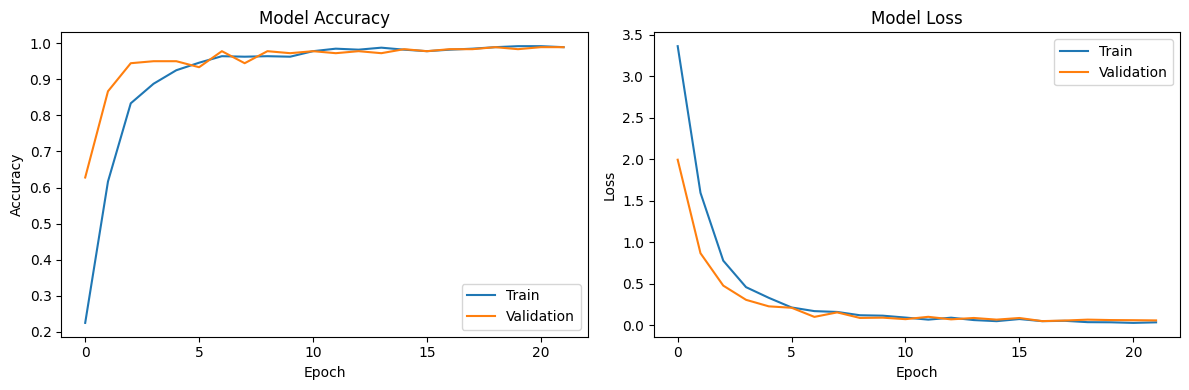

Training history telah disimpan sebagai 'training_history.png'


In [11]:
# Tampilkan visualisasi hyperparameter (opsional, tambahkan jika diperlukan)
import matplotlib.pyplot as plt

# Visualisasi training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("Training history telah disimpan sebagai 'training_history.png'")